First, we define a right-handed coordinate system as follows:
the $x$-axis points to the right, the $y$-axis points forward, and the $z$-axis points upward. It is called the spherical coordinate system.
The azimuthal angle $\phi$ is defined as the angle measured in the $xy$-plane from the positive $y$-axis toward the positive x-axis.
The elevation angle $\theta$ is defined as the angle measured from the $xy$-plane toward the positive $z$-axis.
It can be converted to Cartesian coordinates (x, y, z) as follows:
$$ 
\begin{bmatrix}
x\\y\\z
\end{bmatrix}
=
\begin{bmatrix}
r \cos\theta \sin\phi\\
r \cos\theta \cos\phi\\
r \sin\theta\\
\end{bmatrix}
$$

Next, we consider a uniform rectangular array (URA) with $N\times M$ elements placed in this coordinate system.
It is assumed that the array elements are arranged in the $xz$-plane,
with $N$ elements along the $x$-axis and $M$ elements along the $z$-axis.
The spacing between adjacent elements is $d_x$ in the x direction and $d_z$ in the $z$ direction.
The center of the array is located at the origin.

<img src="../images/03_coordinate_system_of_URA.svg" width="600" style="background-color: white;">

In the previous notebook, we conducted a simulation to synthesize IF signals for a 77 GHz radar with a ULA.
In this notebook, we simulate a URA using 4TX and 4RX MIMO system, placed in the coordinate system defined above. 
The chirp configuration is USRR, the same as in the previous notebook. 
The procedures and methods from the previous simulation have been adapted for the URA configuration.


In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from radar_simulation import ChirpConfiguration
from radar_simulation import MIMOConfiguration
from radar_simulation import FMCWMIMORadar
from radar_simulation import TargetObject
from signal_processing import RangeDopplerFFT
from signal_processing import BeamFormingDOA
from signal_processing import MUSIC
from sensor import MIMOVirtualArray

In [ ]:
# (0) setup
# (0.1) 4x4-URA
num_tx = 4
txl = np.zeros((num_tx, 3))
txl[:,2] = np.arange(num_tx, dtype=np.int32)
num_rx = 4
rxl = np.zeros((num_rx, 3))
rxl[:,0] = np.arange(num_rx, dtype=np.int32)
# (0.2) configuration
cc = ChirpConfiguration()
mc = MIMOConfiguration(txl, rxl, cc.start_lambda, 0.5)
radar = FMCWMIMORadar(cc, mc)
mva = MIMOVirtualArray(mc)
# (0.3) object
objs = list()
objs.append(TargetObject.get_3d_target(7, 1, (5, -10)))
objs.append(TargetObject.get_3d_target(17, -2, (-5, 10)))


Unlike the previous case, the target objects are given not only azimuth angles but also elevation angles.
| Parameter| Object #1 | Object #2 |
| ---- | ---- | ---- |
| range [m] | 7 | 17 |
| $\theta$ [deg]| 5 | -5|
| $\phi$ [deg]| -10 | 10|
| radial velocity [m/s] | 1 | -2 |

The figure below shows the virtual array structure for a 4TX and 4RX MIMO system.
The vertical and horizontal axes represent positions in units of half wavelength.

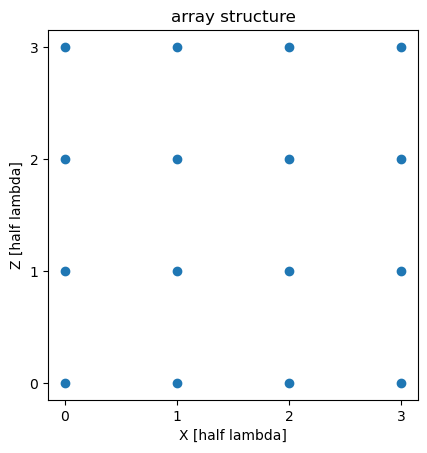

In [ ]:
va_nz = np.nonzero(mva.va_mask)
fig, ax = plt.subplots()
plt.scatter(va_nz[1], va_nz[0])
ax.set_title('array structure')
ax.set_ylabel('Z [half lambda]')
ax.set_xlabel('X [half lambda]')
ax.set_aspect('equal')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# (1) do simulation
num_frames = 10
dc = radar.get_data_cube(num_frames, objs)

Text(0.5, 0, 'Range [m]')

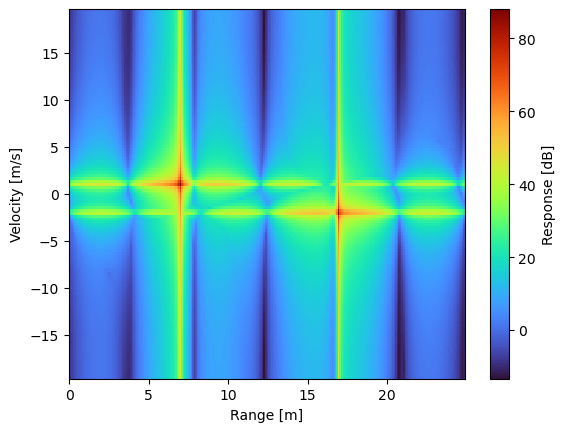

In [ ]:
postproc = RangeDopplerFFT()
rdm = postproc.get_2d_fft(dc)

target_frame = 0
rdm0_dB = np.mean(20 * np.log10((np.abs(rdm[target_frame,:,:,:,:]))), (1, 0))

range_bin = postproc.get_range_bins(cc)
velocity_bin = postproc.get_velocity_bins(cc)

fig, ax = plt.subplots()
cm = ax.pcolor(range_bin, velocity_bin, rdm0_dB, cmap='turbo')
fig.colorbar(cm, ax=ax, label='Response [dB]')
ax.set_ylabel('Velocity [m/s]')
ax.set_xlabel('Range [m]')

In this simulation, detection points are set in a manner similar to the previous simulation.
Specifically, objects are assumed to be detected at the locations of strong peaks in the range-Doppler map, corresponding to local maxima near (range, velocity) = (7, 1) and (17, -2).
Instead of applying detection algorithms such as CA-CFAR, we simply identify objects by finding the local peaks in the range-Doppler map, which represent the positions of the targets.

After identifying these detection points, Direction of Arrival (DoA) estimation is performed for each detected object.
Beamforming based on FFT is applied to estimate the angle spectrum at each detection point.
Unlike the previous case, this time both azimuth and elevation angles are estimated.

In [ ]:
# in realistic case use somewhat detection method like the CFAR
d_range, d_doppler = (72, 174), (67, 57)

bf = BeamFormingDOA(mva, (128, 128))
angle_bins_el, angle_bins_az = bf.get_angle_bins()
angle_bins_el_degrees = np.rad2deg(angle_bins_el)
angle_bins_az_degrees = np.rad2deg(angle_bins_az)

angle_spectrum = list()
for k, l in zip(d_range, d_doppler):
    signal = mva.get_signal_padded(rdm[target_frame,:,:,l,k])
    s = bf.get_angle_fft(signal)
    angle_spectrum.append(s)

rm = postproc.get_1d_fft(dc)
ram = np.empty((rm.shape[4], bf.angle_fft_size[1]), dtype=rm.dtype)
for k in range(ram.shape[0]):
    signal = mva.get_signal_padded(rm[target_frame,:,:,:,k])
    signal = np.mean(signal, axis=-1)
    s = bf.get_angle_fft(signal)
    s = np.mean(s, axis=0) # azimuth only
    ram[k,:] = s

To estimate both azimuth and elevation angles, a two-dimensional FFT beamforming is applied to the detected objects.
As a result, the angle spectrum becomes two-dimensional, where one axis corresponds to azimuth and the other to elevation.

It should be noted that, since the angle space is represented in spherical coordinates, azimuth and elevation are not completely independent.
Specifically, the azimuth angle reaches $\pm\pi/2$ only when the elevation angle is $0$.
Conversely, when the elevation angle is $\pi/2$, the azimuth angle must be $0$.

Similarly, for constructing the range-azimuth map, we first average the signal over the Doppler velocities.
Then, for each range bin, FFT-based beamforming is performed to compute the two-dimensional angle spectrum.
Next, the angle spectrum is averaged over the elevation (vertical) dimension to obtain a one-dimensional azimuth spectrum.
These spectra are stacked together to form a two-dimensional range-azimuth map, where peaks correspond to the detected objects' positions.

Object 1, Theta: 5.379378991111861, Phi: -9.941077947065368, R:7.026385734375
Object 2, Theta: -5.379378991112252, Phi: 9.941077947064977, R:16.98043219140625


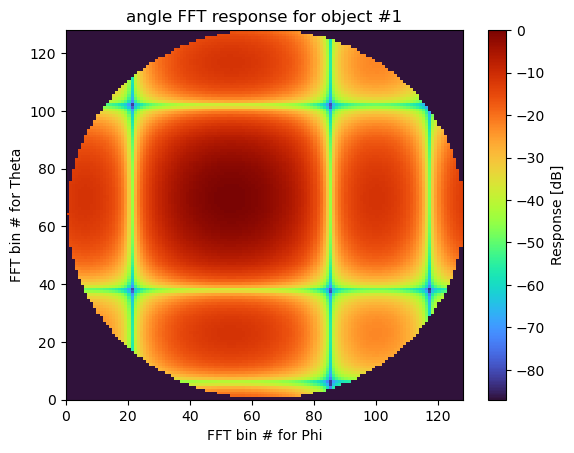

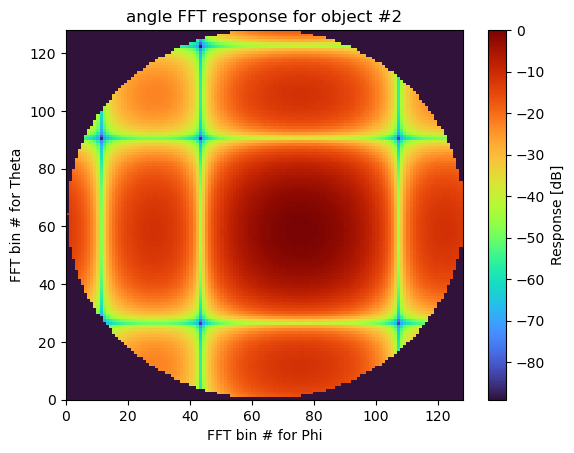

In [ ]:
az_bin = angle_bins_az_degrees.shape[0] // 2

angle_spectrum_power_dB = list()
for s in angle_spectrum:
    p = 20 * np.log10(np.abs(s))
    p -= np.max(p)
    angle_spectrum_power_dB.append(p)

valid_angle_mask = mva.get_valid_angle_mask(angle_bins_az)

# for visualization only
s_mat_index = np.where(valid_angle_mask)
for k in range(len(angle_spectrum_power_dB)):
    invalid_value = np.min(angle_spectrum_power_dB[k])
    s_masked = np.full(valid_angle_mask.shape, invalid_value, dtype=invalid_value.dtype)
    s_masked[s_mat_index[0], s_mat_index[1]] = angle_spectrum_power_dB[k][s_mat_index[0], s_mat_index[1]]
    fig, ax = plt.subplots()
    cm = ax.pcolor(s_masked, cmap='turbo')
    fig.colorbar(cm, ax=ax, label='Response [dB]')
    ax.set_xlabel('FFT bin # for Phi')
    ax.set_ylabel('FFT bin # for Theta')
    ax.set_title('angle FFT response for object #{}'.format(k + 1))

    el_max, az_max = np.unravel_index(np.argmax(s_masked), s_masked.shape)
    print('Object {}, Theta: {}, Phi: {}, R:{}'.format(k + 1, angle_bins_el_degrees[el_max], angle_bins_az_degrees[el_max, az_max], range_bin[d_range[k]]))


For object #1, a strong peak can be observed in the angle spectrum at $(\theta, \phi) = (5^\circ, -10^\circ)$.
Similarly, for object #2, a strong peak appears at $(\theta, \phi) = (-5^\circ, 10^\circ)$.
These strong peaks indicate the estimated directions of arrival for each object in terms of both azimuth and elevation angles.

Text(0, 0.5, 'Range [m]')

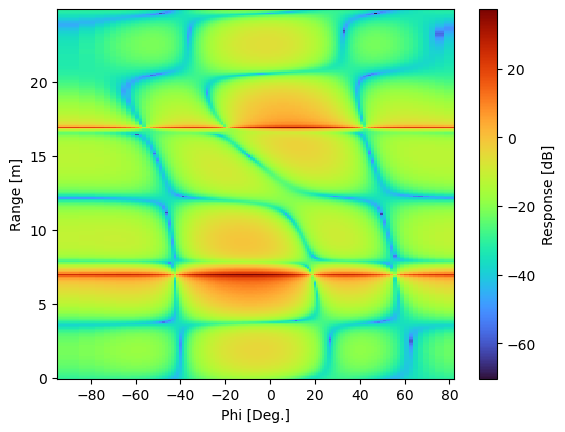

In [ ]:
ram_dB = 20 * np.log10(np.abs(ram))

fig, ax = plt.subplots()
cm = ax.pcolor(angle_bins_az_degrees[az_bin], range_bin, ram_dB, cmap='turbo')
fig.colorbar(cm, ax=ax, label='Response [dB]')
ax.set_xlabel('Phi [Deg.]')
ax.set_ylabel('Range [m]')

Text(0, 0.5, 'Range [m]')

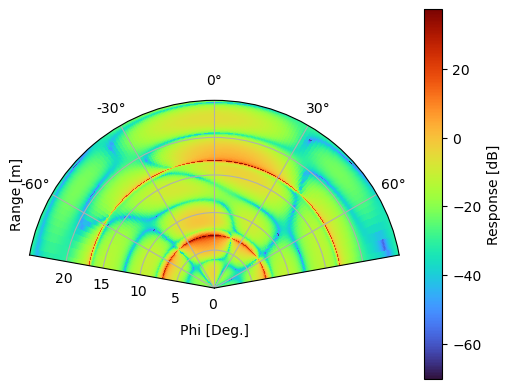

In [ ]:
lim_angle = np.max(angle_bins_az[az_bin])
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
cm = ax.pcolor(angle_bins_az[az_bin], range_bin, ram_dB, cmap='turbo')
fig.colorbar(cm, ax=ax, label='Response [dB]')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetalim([-lim_angle, lim_angle])
ax.set_xlabel('Phi [Deg.]', labelpad=-40)
ax.set_ylabel('Range [m]')

Instead of FFT beamforming, the two-dimensional MUSIC method is applied.
In this method, the subspace is constructed by rearranging the two-dimensional signal into a one-dimensional vector,
after which eigenvalue decomposition is performed.
When rearranging into a one-dimensional vector, pairs of azimuth and elevation angles that are invalid due to the dependency in spherical coordinates—where azimuth and elevation cannot be independently specified—are dropped.
This enables high-resolution estimation of both azimuth and elevation angles for each detected object.

In [ ]:
rank_est_1 = lambda x:  1 # dummy functor
rank_est_0 = lambda x:  0 # dummy functor
mu1 = MUSIC(rank_est_1)
mu0 = MUSIC(rank_est_0)

steering, steering_mask = mva.get_steering_vector_matrix((angle_bins_el, angle_bins_az[az_bin]))

rmm = np.empty((rm.shape[4], steering.shape[1]), dtype=rm.dtype) # range-music-map
for k in range(rmm.shape[0]):
    signal = mva.get_signal(rm[target_frame,:,:,:,k])
    Rxx = np.dot(signal, signal.conj().T) / signal.shape[1]
    if k in d_range:
        rmm[k,:] = mu1.get_music_spetrum(Rxx, steering) # object is detected
    else:
        rmm[k,:] = mu0.get_music_spetrum(Rxx, steering) # object is not detected

Object 1, Theta: 5.379378991111861, Phi: -9.941077947065368, R:7.026385734375
Object 2, Theta: -5.379378991112252, Phi: 9.941077947064977, R:16.98043219140625


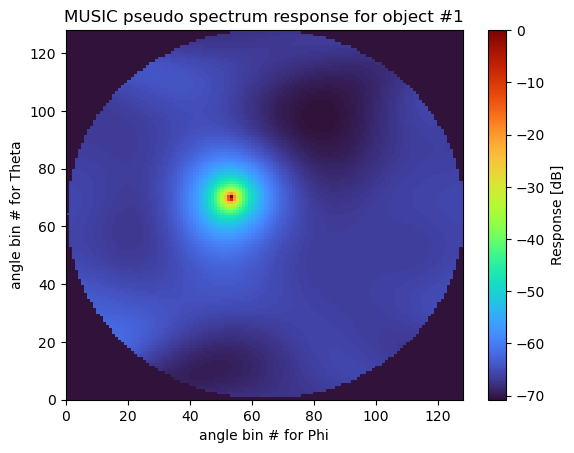

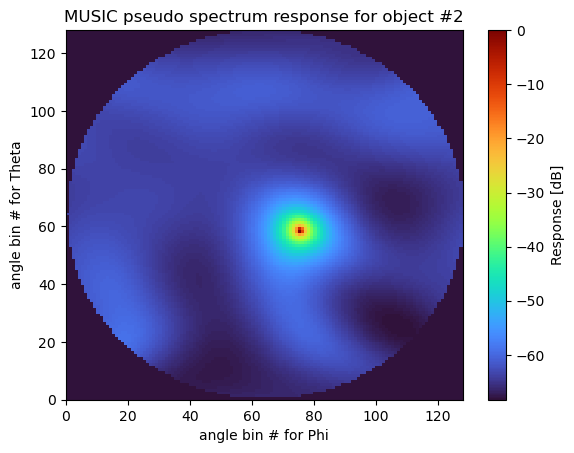

In [ ]:
# music-spectrum for detected object
music_spectrum = np.empty((len(d_range), rmm.shape[1]), dtype=signal.dtype)
for k, kk in zip(d_range, range(len(d_range))):
    music_spectrum[kk, :] = rmm[k, :]

music_spectrum_power_dB = list()
for s in music_spectrum:
    p = 20 * np.log10(np.abs(s))
    p -= np.max(p)
    music_spectrum_power_dB.append(p)

# for visualization only
s_mat_index = np.where(steering_mask)

for k in range(len(angle_spectrum_power_dB)):
    invalid_value = np.min(music_spectrum_power_dB[k])
    s_masked = np.full(steering_mask.shape, invalid_value, dtype=invalid_value.dtype)
    s_masked[s_mat_index[0], s_mat_index[1]] = music_spectrum_power_dB[k]
    fig, ax = plt.subplots()
    cm = ax.pcolor(s_masked, cmap='turbo')
    fig.colorbar(cm, ax=ax, label='Response [dB]')
    ax.set_xlabel('angle bin # for Phi')
    ax.set_ylabel('angle bin # for Theta')
    ax.set_title('MUSIC pseudo spectrum response for object #{}'.format(k + 1))

    el_max, az_max = np.unravel_index(np.argmax(s_masked), s_masked.shape)
    print('Object {}, Theta: {}, Phi: {}, R:{}'.format(k + 1, angle_bins_el_degrees[el_max], angle_bins_az_degrees[el_max, az_max], range_bin[d_range[k]]))

Compared to FFT Beamforming, the peaks obtained from the two-dimensional MUSIC method are sharper and more distinct.